*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/distant_position.ipynb)*

# Investigating the Distant Position and Tenses
## (ביום ההוא)
### Cody Kingham
<a href="../../docs/sponsors.md"><img height=200px width=200px align="left" src="../../docs/images/CambridgeU_BW.png"></a>

In [1]:
! echo "last updated:"; date

last updated:
Thu 12 Mar 2020 11:27:20 GMT


## Introduction

In this notebook we seek to examine phrases that indicate distant position. These were briefly examined in [demonstrative_tenses.ipynb](demonstrative_tenses.ipynb), which likewise included demonstratives expressed with duration, e.g. עד היום הזה, but did not exclusively focus on positional adverbials, e.g. ביום ההוא.

### "that" future or present?

One of the motivations of the time adverbial study is to better understand the verb tenses. Is inherent verb tense a large factor in collocation patterns of future/past time adverbials? One of the challenges in using demonstrative adverbials for this task is that they only indicate distance not direction. Presumably other factors, especially the main verb tense, would intervene to provide directionality. But in this study it is precisely the verb tense we want to understand better through the lens of the time adverbials. Is there then a way to avoid circularly labeling some adverbials as "future" and others as "past?

#### Clustering based on context

One way to mitigate the circularity is to rely on the combined frequency of other verbs within the context of a distant adverbial. For instance, instead of only paying attention to the verb used alongside with the adverbial, record what verb forms are found around a given context. Those contexts can then be clustered based on the proportional representation of certain verb types. In theory, future and past contexts will cluster together.

One potential problem is that even good clusters would not prove that a given passage is "past" or "future". In the end, it must be human intuition that is used as the final judge. But with coherent clusters we could at least support the argument for a classification. We could also potentially isolate contexts where an unexpected verb form is found alongside an adverbial. 

<hr>

# Python

Now we import the modules and data needed for the analysis.

In [69]:
# standard & data science packages
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['SBL Biblit']
import seaborn as sns
from bidi.algorithm import get_display # bi-directional text support for plotting
from paths import main_table, figs
fig_path = figs.joinpath('distant_position/')

# custom packages (see /tools)
from tf_tools.load import load_tf
from positions import Walker
from stats.significance import contingency_table, apply_fishers
from stats.pca import apply_pca

# launch Text-Fabric with custom data
TF, API, A = load_tf(features='domain',silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L # corpus analysis methods

# load and set up project dataset
times_full = pd.read_csv(main_table, sep='\t')
times_full.set_index(['node'], inplace=True)
times = times_full[~times_full.classi.str.contains('component')] # select singles

## Isolate and examine distant positional adverbials

In [3]:
distant_positions = times[(times.leading_prep == 'ב') & (times.demon_dist == 'far')]

distant_positions.shape

(311, 35)

So we have 311 distant positional adverbials. We can look at a sampling:

In [4]:
distant_positions[['ref', 'text', 'clause']].head(40)

,ref,text,clause
node,,,
1446905,Gen 15:18,בַּיֹּ֣ום הַה֗וּא,בַּיֹּ֣ום הַה֗וּא כָּרַ֧ת יְהוָ֛ה אֶת־אַבְרָ֖ם...
1446925,Gen 19:35,גַּ֣ם בַּלַּ֧יְלָה הַה֛וּא,וַתַּשְׁקֶ֜יןָ גַּ֣ם בַּלַּ֧יְלָה הַה֛וּא אֶת־...
1446934,Gen 21:22,בָּעֵ֣ת הַהִ֔וא,וַֽיְהִי֙ בָּעֵ֣ת הַהִ֔וא
1446960,Gen 26:12,בַּשָּׁנָ֥ה הַהִ֖וא,וַיִּמְצָ֛א בַּשָּׁנָ֥ה הַהִ֖וא מֵאָ֣ה שְׁעָרִ...
1446965,Gen 26:24,בַּלַּ֣יְלָה הַה֔וּא,וַיֵּרָ֨א אֵלָ֤יו יְהוָה֙ בַּלַּ֣יְלָה הַה֔וּא
1446967,Gen 26:32,בַּיֹּ֣ום הַה֗וּא,וַיְהִ֣י׀ בַּיֹּ֣ום הַה֗וּא
1447004,Gen 30:35,בַּיֹּום֩ הַה֨וּא,וַיָּ֣סַר בַּיֹּום֩ הַה֨וּא אֶת־הַתְּיָשִׁ֜ים ...
1447024,Gen 32:14,בַּלַּ֣יְלָה הַה֑וּא,וַיָּ֥לֶן שָׁ֖ם בַּלַּ֣יְלָה הַה֑וּא
1447026,Gen 32:22,בַּלַּֽיְלָה־הַה֖וּא,וְה֛וּא לָ֥ן בַּלַּֽיְלָה־הַה֖וּא בַּֽמַּחֲנֶֽה׃


We will also make one additional requirement: we only want those cases where the main verb tense is not infinitival or imperatival.

In [5]:
dist_data = distant_positions[distant_positions.tense.isin(['wyqtl', 'yqtl', 'qtl', 'wqtl', 'ptcp'])]

dist_data.shape

(298, 35)

We've still kept a large sample of the data. That is good.

## Context-based clustering 

We now have ~300 cases of distant positional adverbials ready for processing. Instead of classifying each one as "future" or "past", we want the adverbials to "tell us" where they belong based on the types of contexts they appear in.

In order to do this, we'll collect data about the kinds of verbs which occur within the passage of a given target adverbial. We can use a contextual window to do this. In such a case, we will collect 5 verbs on either side of the adverbial. The verbs should come from independent clauses (e.g. not relative clauses). We can use the BHSA data to exclude dependent clauses. In some cases we may not have enough data for a given context, for instance if an adverbial occurs towards the end of a book. We can temporarily set these cases aside.

In [6]:
def good_clause(clause):
    """Validate verbal, independent, clauses"""
    requirements = [
        F.rela.v(clause) == 'NA',
        F.kind.v(clause) == 'VC',
    ]
    if all(requirements):
        return clause
    
#class go_decider:
#    def __init__(self, start_clause):
#        self.domain = F.domain.v(start_clause)
#    def keep_walking(self, clause):
#        """Decide whether to continue with a walk.
#    
#        Walks will be stopped when quotation boundary crossed
#        """
#        if self.domain == 'Q' and F.domain.v(clause) != 'Q':
#            return False
#        elif self.domain != 'Q' and F.domain.v(clause) == 'Q':
#            return False
#        else:
#            return True

In [9]:
contexts = {}
bad_contexts = {}
quotations = 0

for ta in dist_data.index:
    ta_clause = L.u(ta,'clause')[0]
    book = L.u(ta,'book')[0]
    book_clauses = L.d(book,'clause')
    wk = Walker(ta_clause, book_clauses)
    
    context = []
    window = 3
    for direction in (wk.back, wk.ahead):
        direction_clauses = []
        for cl in direction(good_clause, every=True, go=lambda a: True):
            if len(direction_clauses) < window:
                direction_clauses.append(cl)
            else:
                context.extend(direction_clauses)
                break
                
    if len(context) == window*2:
        # check contexts for quotation bounds
        domains = set(F.domain.v(cl) for cl in context)
        if 'Q' in domains and domains.issubset({'Q'}):
            contexts[ta] = context
            quotations += 1
        elif 'Q' in domains:
            bad_contexts[ta] = context
        else:
            contexts[ta] = context
    else:
        bad_contexts[ta] = context

In [11]:
print(f'{quotations} quotations logged')

87 quotations logged


In [12]:
len(contexts)

163

In [13]:
len(bad_contexts)

135

In [14]:
contexts.keys()

dict_keys([1446967, 1447150, 1447214, 1447230, 1447488, 1447547, 1447564, 1447748, 1447764, 1447766, 1447767, 1447790, 1447821, 1447824, 1447910, 1447947, 1447948, 1447949, 1448009, 1448021, 1448036, 1448038, 1448041, 1448057, 1448070, 1448073, 1448074, 1448078, 1448081, 1448156, 1448159, 1448207, 1448219, 1448280, 1448298, 1448310, 1448311, 1448317, 1448342, 1448353, 1448362, 1448363, 1448367, 1448431, 1448465, 1448490, 1448568, 1448584, 1448596, 1448714, 1448715, 1448769, 1448850, 1448851, 1448878, 1448994, 1449042, 1449106, 1449110, 1449159, 1449178, 1449179, 1449183, 1449199, 1449200, 1449201, 1449202, 1449212, 1449214, 1449217, 1449233, 1449234, 1449240, 1449241, 1449242, 1449243, 1449244, 1449251, 1449253, 1449255, 1449256, 1449262, 1449266, 1449267, 1449277, 1449278, 1449279, 1449286, 1449290, 1449294, 1449462, 1449465, 1449467, 1449469, 1449470, 1449474, 1449557, 1449574, 1449577, 1449609, 1449640, 1449641, 1449662, 1449666, 1449667, 1449673, 1449759, 1449766, 1449767, 1449783,

In [18]:
context_counts = collections.defaultdict(lambda:collections.Counter())

for ta, context in contexts.items():
    for cl in context:
        # get pred phrases for verbs
        preds = [ph for ph in L.d(cl, 'phrase') if F.function.v(ph) in {'Pred','PreO','PreS'}]
        verbs = [w for w in L.d(cl,'word') if F.pdp.v(w) == 'verb']
        if preds:
            verb = next(w for w in L.d(preds[0],'word') if F.pdp.v(w) == 'verb')
        else:
            verb = next(iter(verbs))
        tense = F.vt.v(verb)
        if not tense.startswith('inf'):
            context_counts[ta][tense] += 1

In [19]:
context_counts[1450025]

Counter({'wqtl': 3, 'impv': 1, 'qtl': 2})

In [20]:
con_counts = pd.DataFrame.from_dict(context_counts, orient='index').fillna(0)

con_counts.head()

,wyqtl,wqtl,ptca,yqtl,qtl,impv,ptcp
1446967,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1447230,4.0,0.0,0.0,0.0,2.0,0.0,0.0
1447764,4.0,0.0,0.0,0.0,2.0,0.0,0.0
1447766,1.0,0.0,0.0,2.0,2.0,0.0,0.0
1447821,3.0,0.0,0.0,0.0,3.0,0.0,0.0


In [21]:
con_counts.shape

(163, 7)

Now we normalize the counts with a simple ratio.

In [22]:
con_ratios = con_counts.div(con_counts.sum(1), axis=0)

con_ratios.head()

,wyqtl,wqtl,ptca,yqtl,qtl,impv,ptcp
1446967,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1447230,0.666667,0.0,0.0,0.0,0.333333,0.0,0.0
1447764,0.666667,0.0,0.0,0.0,0.333333,0.0,0.0
1447766,0.200000,0.0,0.0,0.4,0.400000,0.0,0.0
1447821,0.500000,0.0,0.0,0.0,0.500000,0.0,0.0


## Principle Component Cluster

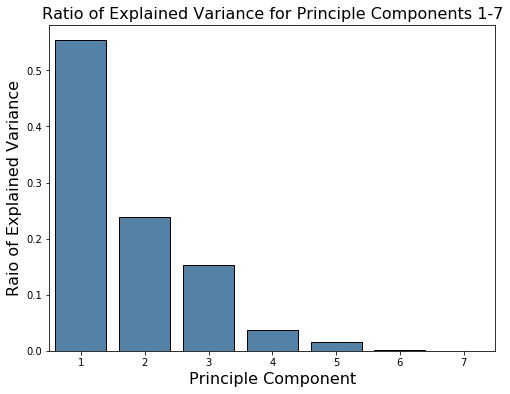

In [26]:
components, loadings = apply_pca(con_ratios, 0, 1)

In [29]:
components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
1446967,0.758548,-0.383174,-0.109888,-0.061601,0.015624,-0.000605,-8.613452e-17
1447230,0.542203,0.015954,0.014583,-0.069455,-0.008016,-0.001123,-2.368447e-17
1447764,0.542203,0.015954,0.014583,-0.069455,-0.008016,-0.001123,-2.368447e-17
1447766,-0.008785,0.221329,-0.175919,-0.071653,-0.020637,-0.000282,4.743919e-17
1447821,0.434030,0.215519,0.076818,-0.073382,-0.019836,-0.001381,6.305170e-17


In [30]:
loadings.head()

,wyqtl,wqtl,ptca,yqtl,qtl,impv,ptcp
1,0.329248,-0.163016,0.009688,-0.215602,0.050647,-0.011662,0.000696
2,-0.107164,-0.120245,0.007426,-0.018585,0.230753,0.007278,0.000537
3,-0.037736,0.147397,-0.007418,-0.159055,0.046392,0.010122,0.000297
4,-0.026562,-0.021852,0.098160,-0.026737,-0.029187,0.004710,0.001469
5,-0.009567,-0.015130,-0.016580,-0.011022,-0.014799,0.067130,-0.000032


In [64]:
loadings['wyqtl'][:2]

1    0.329248
2   -0.107164
Name: wyqtl, dtype: float64

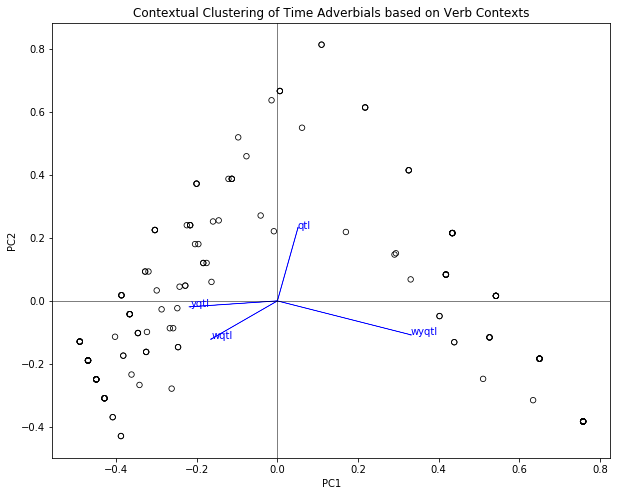

In [73]:
x,y = components.iloc[:,:2].values.T

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y, color='', edgecolor='black', linewidth=0.8, s=30)
ax.axhline(color='black', linewidth=0.5)
ax.axvline(color='black', linewidth=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for feature in loadings.columns:
    fx,fy = loadings[feature][:2]
    if abs(fx) > 0.04 or abs(fy) > 0.04:
        ax.arrow(0,0, fx, fy, color='blue', linewidth=0.5)
        ax.text(fx,fy, feature, color='blue')

plt.savefig(fig_path.joinpath('contextual_clustering.png'), dpi=300, bbox_inches='tight')
plt.title('Contextual Clustering of Time Adverbials based on Verb Contexts')
plt.show()

### Examining results

We have two clear larger clusters and separation happening between adverbials with a stronger preference for wayyiqtol from those that prefer yiqtol and weqatal. 

Let's look at some of the results closer to the center. These lie somewhere between $[-0.1, 0.1]$

In [103]:
fuzzy_borders = components.loc[(components.PC1 > -0.1)&(components.PC1 < 0.1)]

def show_contexts(ta_iterable):
    for ta in sorted(ta_iterable):
        context = contexts[ta]
        show_context = sorted(context + [L.u(ta,'clause')[0]])
        highlights = L.d(ta,'word')
        print(f'Context for adverbial {ta}')
        print(components.loc[ta][:2])
        print(context_counts[ta])
        for cl in show_context:
            A.plain(cl, highlights=highlights, isLinked=False)
        print()
        
show_contexts(fuzzy_borders.index)

Context for adverbial 1447766
PC1   -0.008785
PC2    0.221329
Name: 1447766, dtype: float64
Counter({'qtl': 2, 'yqtl': 2, 'wyqtl': 1})



Context for adverbial 1447790
PC1    0.006136
PC2    0.666959
Name: 1447790, dtype: float64
Counter({'qtl': 5, 'yqtl': 1})



Context for adverbial 1447948
PC1    0.006136
PC2    0.666959
Name: 1447948, dtype: float64
Counter({'qtl': 5, 'yqtl': 1})



Context for adverbial 1447949
PC1    0.061126
PC2    0.550255
Name: 1447949, dtype: float64
Counter({'qtl': 4, 'impv': 2})



Context for adverbial 1448342
PC1   -0.041574
PC2    0.271288
Name: 1448342, dtype: float64
Counter({'ptca': 3, 'qtl': 2, 'yqtl': 1})



Context for adverbial 1449266
PC1   -0.097241
PC2    0.519707
Name: 1449266, dtype: float64
Counter({'qtl': 4, 'yqtl': 2})



Context for adverbial 1449279
PC1   -0.076824
PC2    0.459669
Name: 1449279, dtype: float64
Counter({'qtl': 4, 'wqtl': 1, 'yqtl': 1})



Context for adverbial 1449759
PC1   -0.014540
PC2    0.637508
Name: 1449759, dtype: float64
Counter({'qtl': 4, 'yqtl': 1})



Context for adverbial 1450106
PC1    0.006136
PC2    0.666959
Name: 1450106, dtype: float64
Counter({'qtl': 5, 'yqtl': 1})
